## PREDICTING HOUSING PRICES IN KING COUNTY

King County Real-Estate is trying to predict home prices for their clients. The aim of this project is to learn more about their county's home prices and the features that affect home prices. We build linear regression models to accurately predict the price of homes in their county. This would be useful to King County homeowners who are looking to sell their home in order to get an idea of their home's value before deciding to list it with a realtor.

#### IMPORT LIBRARIES AND DATA

In [1]:
# importing the necessary libraries
import itertools
import pandas as pd
import numpy as np
import json
from numbers import Number
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import the data
df = pd.read_csv('../data/kc_house_data.csv')
#previewing the data
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


#### DATA CLEANING

Assigning new variable to the relevant variables

In [3]:
df['date'].sort_values()

12076    1/10/2015
19359    1/12/2015
2548     1/12/2015
18398    1/12/2015
11086    1/12/2015
           ...    
19256     9/9/2014
66        9/9/2014
20288     9/9/2014
12438     9/9/2014
15702     9/9/2014
Name: date, Length: 21597, dtype: object

In [4]:
df.date =  pd.to_datetime(df.date, format='%m/%d/%Y')

In [5]:
df.waterfront.value_counts()

waterfront
0.0    19075
1.0      146
Name: count, dtype: int64

In [6]:
df['waterfront'] = df['waterfront'].fillna(value=0.0)

In [7]:
df.view.value_counts()

view
0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: count, dtype: int64

In [8]:
df = df.dropna(subset=['view'])

In [9]:
df.yr_renovated.value_counts()

yr_renovated
0.0       16961
2014.0       73
2013.0       31
2003.0       31
2007.0       30
          ...  
1951.0        1
1953.0        1
1946.0        1
1976.0        1
1948.0        1
Name: count, Length: 70, dtype: int64

In [10]:
df['yr_renovated'] = df['yr_renovated'].fillna(value=0.0)

In [11]:
df.shape

(21534, 21)

In [12]:
df.sqft_basement.value_counts()

sqft_basement
0.0       12798
?           452
600.0       216
500.0       209
700.0       207
          ...  
3480.0        1
1840.0        1
2730.0        1
2720.0        1
248.0         1
Name: count, Length: 302, dtype: int64

In [13]:
# assuming ? means no basement
df.sqft_basement = df.sqft_basement.replace('?', '0.0')

In [14]:
# getting counts for each value in condition column
df['condition'].value_counts()

condition
3    13981
4     5657
5     1697
2      170
1       29
Name: count, dtype: int64

In [15]:
#counts for each value in zipcode column
df['zipcode'].value_counts()

zipcode
98103    601
98038    586
98115    580
98052    573
98117    553
        ... 
98102    104
98010    100
98024     79
98148     57
98039     50
Name: count, Length: 70, dtype: int64

In [16]:
df.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront              float64
view                    float64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement            object
yr_built                  int64
yr_renovated            float64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

In [17]:
# Convert to float
df['sqft_basement'] = df['sqft_basement'].astype(float)

In [18]:
df['date'] = pd.to_datetime(df['date'])

In [19]:
#checking for duplicates
duplicates = df[df.duplicated()]
print(len(duplicates))

0


In [20]:
df.describe()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.153400e+04,21534,2.153400e+04,21534.000000,21534.000000,21534.000000,2.153400e+04,21534.000000,21534.000000,21534.000000,...,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000,21534.000000
mean,4.582351e+09,2014-10-29 01:53:20.780161536,5.400577e+05,3.373038,2.115712,2079.827854,1.509060e+04,1.494126,0.006734,0.233863,...,7.657425,1788.557537,285.244311,1971.002275,68.866722,98077.939352,47.560180,-122.213948,1986.299944,12751.079502
min,1.000102e+06,2014-05-02 00:00:00,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,...,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123212e+09,2014-07-22 00:00:00,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,...,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471200,-122.328000,1490.000000,5100.000000
50%,3.904945e+09,2014-10-16 00:00:00,4.500000e+05,3.000000,2.250000,1910.000000,7.617000e+03,1.500000,0.000000,0.000000,...,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.230000,1840.000000,7620.000000
75%,7.312175e+09,2015-02-17 00:00:00,6.450000e+05,4.000000,2.500000,2550.000000,1.068775e+04,2.000000,0.000000,0.000000,...,8.000000,2210.000000,550.000000,1997.000000,0.000000,98118.000000,47.678100,-122.125000,2360.000000,10083.000000
max,9.900000e+09,2015-05-27 00:00:00,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,...,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000
std,2.876779e+09,NaN,3.660596e+05,0.926410,0.768602,917.446520,4.138021e+04,0.539806,0.081783,0.765686,...,1.172643,827.745641,439.334095,29.376044,364.314552,53.506639,0.138528,0.140735,685.121001,27255.483308


In [21]:
df.loc[df['bedrooms'] > 15]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


In [22]:
# Getting rid of the house with 33 bedrooms and 1 bathroom (outlier)
df = df.loc[df['bedrooms'] < 15]

#### DATA ANALYSIS

In [23]:
df['yr_built'].value_counts().sort_values()

yr_built
1934     21
1935     24
1902     27
1901     29
1933     30
       ... 
2003    419
2004    430
2005    448
2006    453
2014    558
Name: count, Length: 116, dtype: int64

In [24]:
print(df.groupby('waterfront')['price'].count())
print(df.groupby('waterfront')['price'].mean())

waterfront
0.0    21388
1.0      145
Name: price, dtype: int64
waterfront
0.0    5.322400e+05
1.0    1.692506e+06
Name: price, dtype: float64


In [25]:
print(df.groupby('condition')['price'].count())
print(df.groupby('condition')['price'].mean())

condition
1       29
2      170
3    13981
4     5657
5     1696
Name: price, dtype: int64
condition
1    341067.241379
2    328178.758824
3    542226.410772
4    520432.244122
5    612221.544811
Name: price, dtype: float64


A heat map to show the correlation of each column to decide which features will be useful in our model

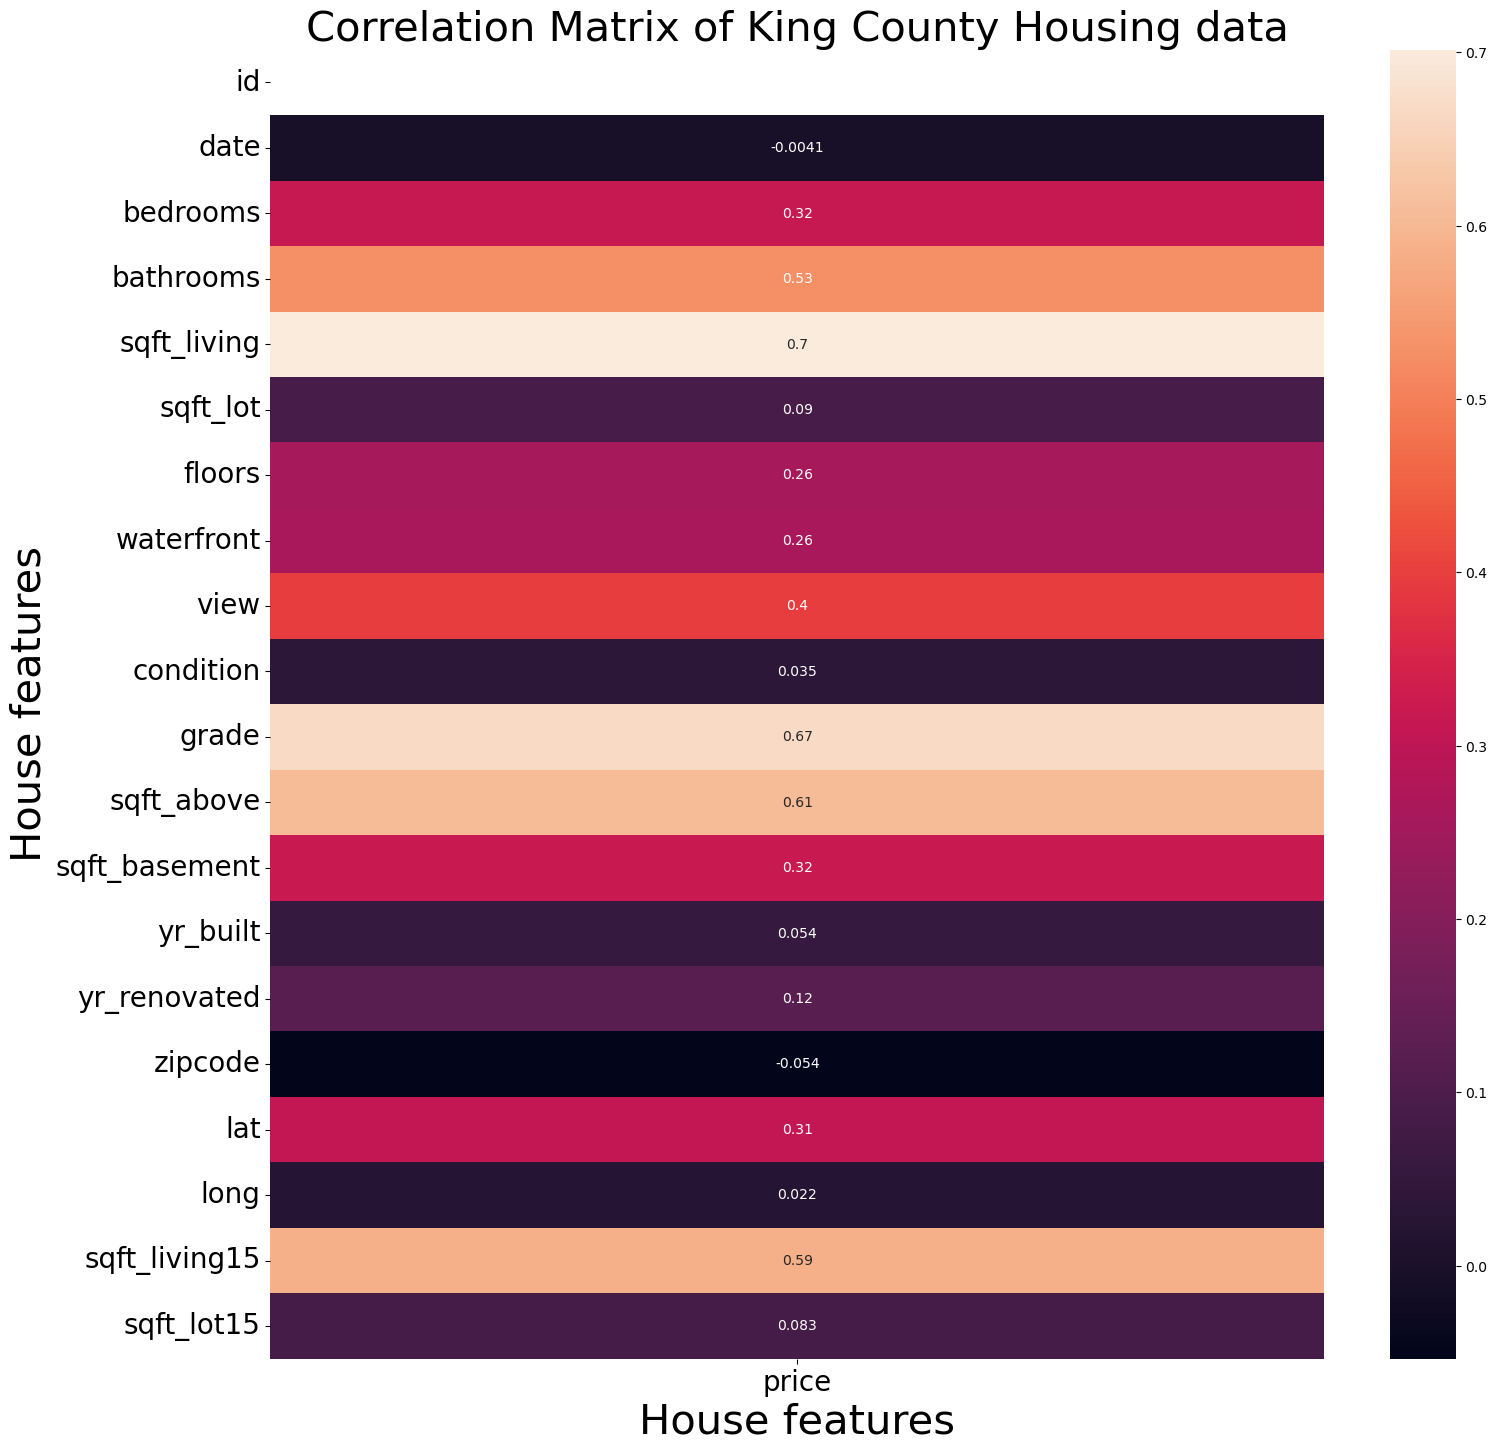

In [26]:
# correlation matrix with duplicated removed
corrMatrix = df.corr()[[column for column in df.columns if column== 'price']].drop(['price'])
matrix = np.triu(corrMatrix)

# plot correlation matrix in heat map with seaborn
fig, ax = plt.subplots(figsize=(17,17)) 
sns.heatmap(corrMatrix, annot=True, mask=matrix)

plt.title('Correlation Matrix of King County Housing data', size=30)
plt.xlabel('House features', size=30)
plt.ylabel('House features', size=30)
plt.xticks(size=20)
plt.yticks(size=20);